# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


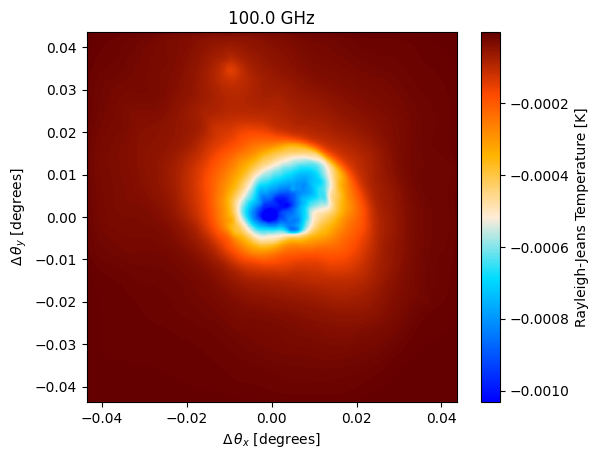

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

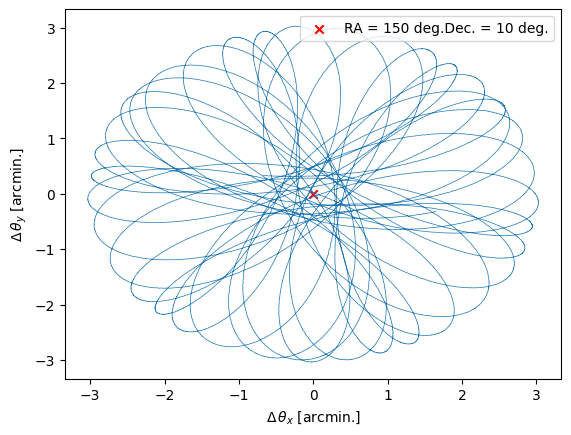

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-17 15:47:09.402 INFO: Initialized base in 1577 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]
2024-10-17 15:47:14.961 INFO: Initialized atmosphere in 5545 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


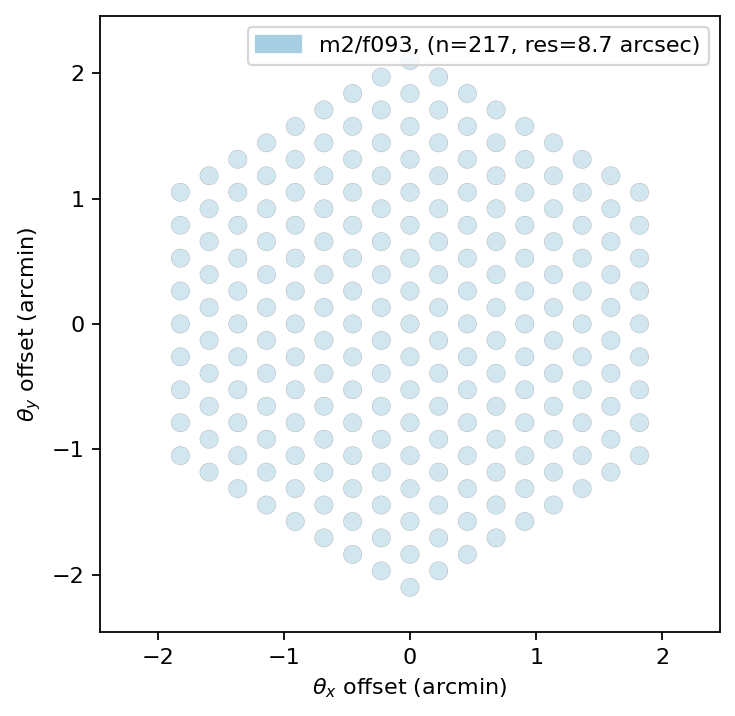

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.95517950e-04, -1.93464859e-04, -1.88953623e-04, ...,
         4.73484603e-04,  4.75580550e-04,  4.79731398e-04],
       [-2.44637148e-04, -2.42584046e-04, -2.38073052e-04, ...,
         4.28137966e-04,  4.30233829e-04,  4.34384486e-04],
       [-1.20327784e-04, -1.18274691e-04, -1.13763510e-04, ...,
         5.49362599e-04,  5.51458535e-04,  5.55609357e-04],
       ...,
       [ 1.22245489e-04,  1.24298485e-04,  1.28811716e-04, ...,
         7.60379647e-04,  7.62476282e-04,  7.66628688e-04],
       [-4.04085676e-04, -4.02032697e-04, -3.97519081e-04, ...,
         2.29233664e-04,  2.31330381e-04,  2.35482973e-04],
       [-7.44897353e-04, -7.42844255e-04, -7.38333172e-04, ...,
        -7.24766649e-05, -7.03808161e-05, -6.62301907e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


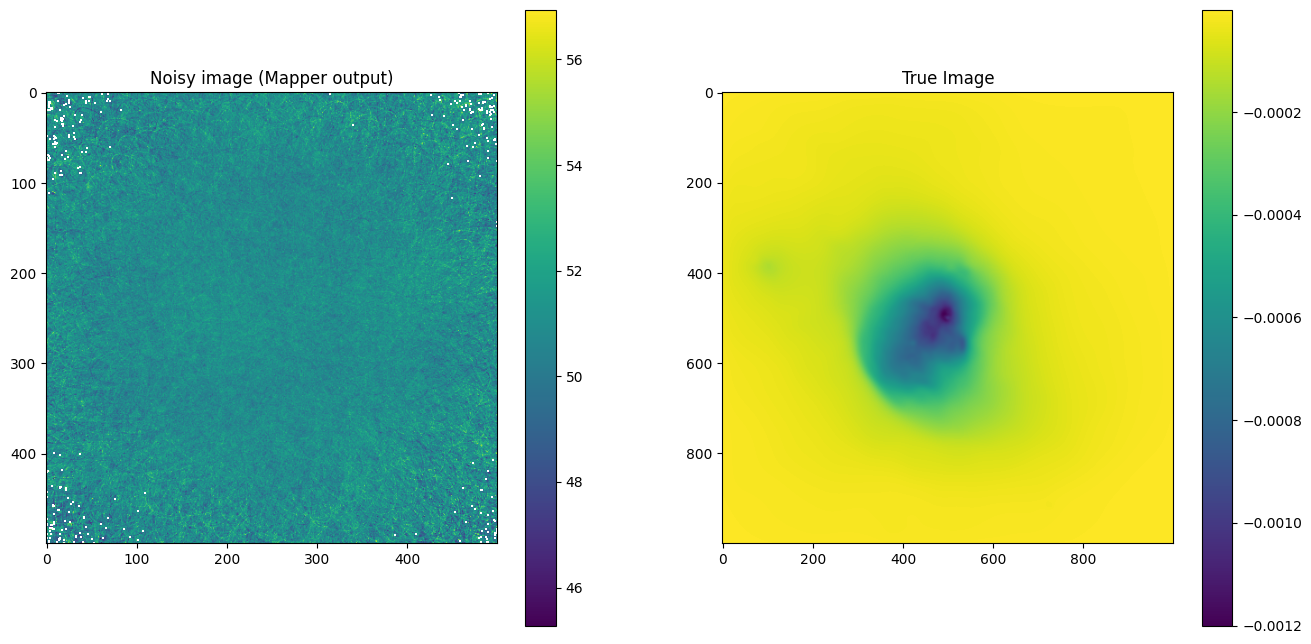

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-17 15:47:29.299 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-17 15:47:29.301 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Prepare noised input TODs:

Noise stddev: 0.00025193844635791856


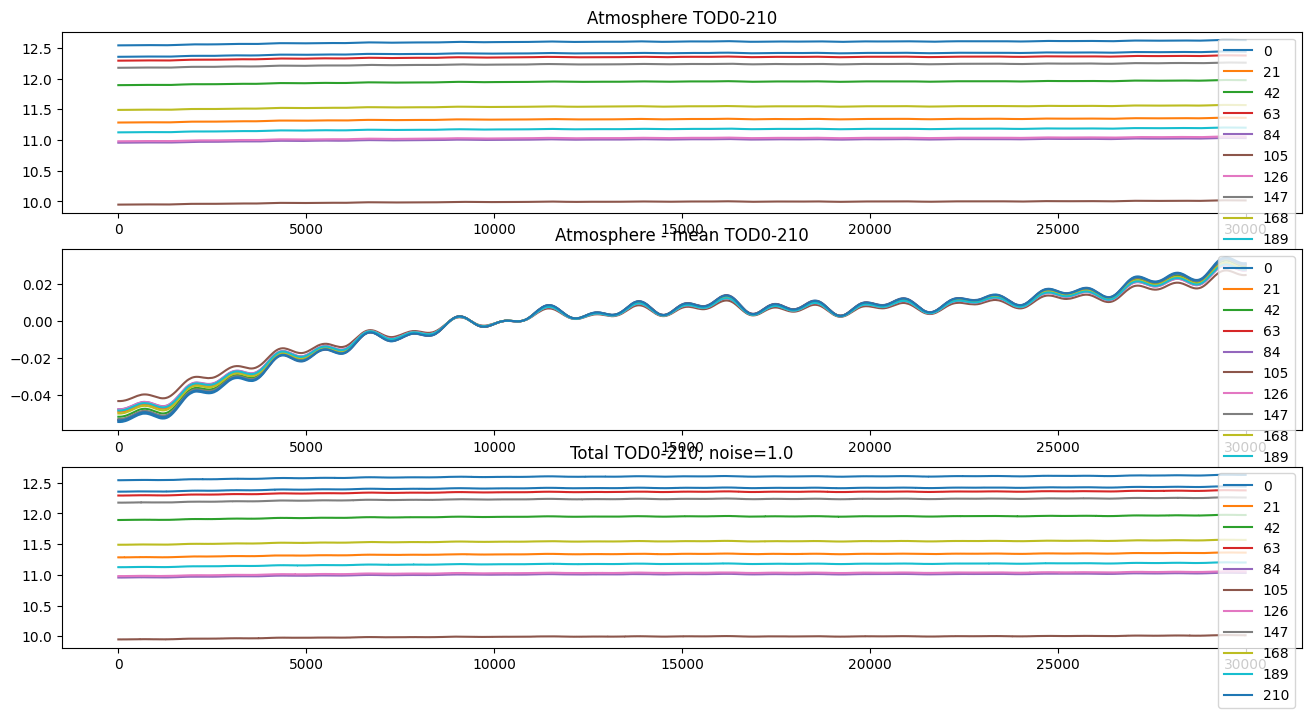

In [7]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods_atmos = tod_truthmap.get_field('atmosphere')

# Add n TODs for atmos:
# n = 1
# n = 2
# n = 10
# n = 100
n = jax_tods_atmos.shape[0]

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# # noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

noised_jax_tod = np.float64(jax_tods_atmos)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean(), label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere - mean TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [8]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [9]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [10]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos[0].mean().compute(), offset_std=(0.0005, 0.001))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.002, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.003), 
    # fluctuations=(0.001, 0.0005),
    fluctuations=(0.002, 0.001),
    # loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    loglogavgslope=(-2.5, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
gp_tod

# Old: default CFM:
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # init params for each TOD:
# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())
# gps_tods

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x145c3dbb9940>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

# Define offset NormalPrior:

mean deviation: 1.5543715009430406e-14
deviation std: 0.5502360275635733
offset for n dets: [ 1.36580669  0.36847472  1.06756661 -0.32319613  0.49772579  0.94672789
  0.24841229 -0.84745329  1.12596153 -0.81351304  0.52993818 -0.46367091
  0.54079807  0.12711511  0.09087081 -0.28482882 -0.65532823 -0.2569013
 -0.53246513 -1.15341145 -0.30372955  0.10354175  0.03564361  0.12447671
  0.00813301 -0.63003696  0.48475857  0.50382064 -0.08460331 -0.58548772
 -0.66636547  0.40422809 -1.03825309  0.19606963  0.16145308  0.82303961
  0.1947313  -0.16272756 -0.37633631 -0.08113965 -0.85118174  1.03688339
  0.7149529  -0.01003718 -0.26460277 -0.03661672 -0.24022965 -0.56401148
  0.10626172 -0.15462887  0.78788095 -0.66883324 -0.80908582  0.83310005
  0.51747411 -0.06084118  0.3698835   0.45953092  0.34518194 -0.33966271
 -0.90393991 -0.10092478  0.02500044  1.11555836 -0.89529752  0.12497413
 -0.80531792  0.55823955  0.21479865 -0.85432614 -0.84710973 -0.75394276
  0.39558111 -0.70536962 -0.19173

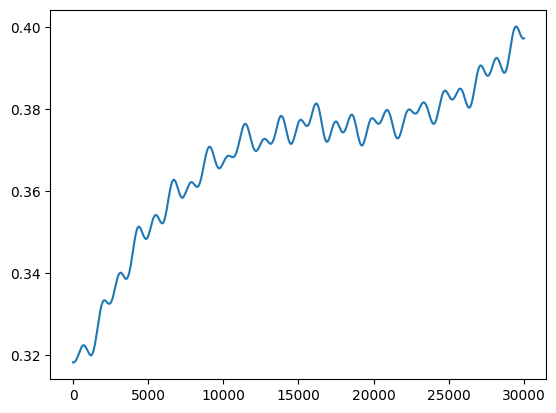

In [11]:
deviation = jax_tods_atmos - jax_tods_atmos.mean()

print("mean deviation:", deviation.mean().compute())
print("deviation std:", deviation.std().compute())

offset_tod = jnp.float64(deviation.mean(axis=1)[:n].compute())
print("offset for n dets:", offset_tod)

plt.plot(deviation[1])

In [12]:
offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
offset_tod = jft.NormalPrior(**offset_dict, name='offset')

offset_tod

NormalPrior(
	<function wrap.<locals>.named_call at 0x145bf5c774c0>,
	domain={'offset': ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer({'offset': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>))})
)

# OLD Signal model:

In [13]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gps_tods)

# CFM - TOD

In [14]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod):
        self.gp_tod = gp_tod
        self.offset_tod = offset_tod
        super().__init__(init = self.gp_tod.init | self.offset_tod.init, domain = self.gp_tod.domain | self.offset_tod.domain )
        # super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x)

        return res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod(x)[:, jax.numpy.newaxis]
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod[:, jax.numpy.newaxis]

signal_response_tod = Signal_TOD(gp_tod, offset_tod)

In [15]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
print(noised_jax_tod.shape)
# truth = noised_jax_tod[:, 100:-100]
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [16]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'offset': ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x145c3da0a0c0>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode

# Draw Prior sample

(217, 30000)


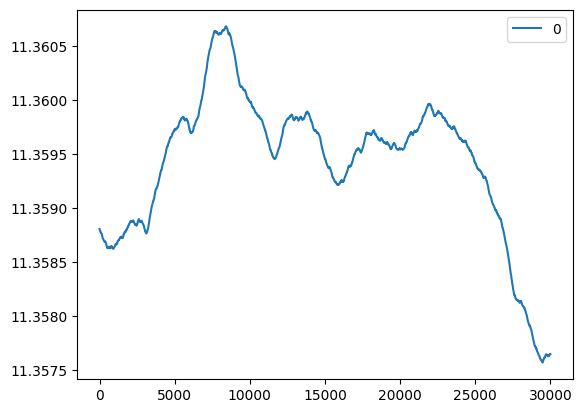

In [17]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [18]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:8.443375e+03 ➽:8.680220e+02
M: Iteration 1 ⛰:+7.427597e+09 Δ⛰:3.494666e+13
M: →:0.25 ↺:False #∇²:12 |↘|:4.345951e+03 ➽:8.680220e+02
M: Iteration 2 ⛰:+5.471805e+09 Δ⛰:1.955791e+09
M: →:1.0 ↺:False #∇²:18 |↘|:1.449213e+04 ➽:8.680220e+02
M: Iteration 3 ⛰:+2.517471e+09 Δ⛰:2.954334e+09
M: →:1.0 ↺:False #∇²:24 |↘|:1.647054e+03 ➽:8.680220e+02
M: Iteration 4 ⛰:+5.897741e+08 Δ⛰:1.927697e+09
M: →:1.0 ↺:False #∇²:30 |↘|:9.725668e+02 ➽:8.680220e+02
M: Iteration 5 ⛰:+4.872153e+08 Δ⛰:1.025588e+08
M: →:1.0 ↺:False #∇²:36 |↘|:7.942903e+02 ➽:8.680220e+02
M: Iteration 6 ⛰:+4.318883e+08 Δ⛰:5.532700e+07
OPTIMIZE_KL: Iteration 0001 ⛰:+4.3189e+08
OPTIMIZE_KL: #(KL minimization steps) 6
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 1.3e+02±     0.0, avg:   +0.027±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
combcf tod fluctuations :: 'reduced χ²:   0.069±     0.0, avg:    +0.26±     0.0, #dof:      1'
combcf tod loglogavgslope:: 'reduced 

In [19]:
samples.pos

Vector(
	{'combcf tod fluctuations': Array(0.26324861, dtype=float64),
	 'combcf tod loglogavgslope': Array(0.71797091, dtype=float64),
	 'combcf xi': Array([[ -0.36540112,   5.07904563,  13.99977312, ...,  -1.21825959,
	        -12.96084143, -13.63011584],
	       [  1.75121502,   4.86430402,  13.11467903, ...,  -1.01401989,
	        -11.88413637, -12.53332942],
	       [  0.99521075,   4.72326107,  13.42895427, ...,  -1.88936402,
	        -13.11809805, -13.32422804],
	       ...,
	       [ -1.55870258,   4.73579619,  12.41921266, ...,  -1.66203399,
	        -12.56599001, -13.06839376],
	       [ -0.25879926,   5.03791308,  13.85098489, ...,  -1.65706471,
	        -11.53372911, -12.15128326],
	       [ -1.33750799,   4.60311552,  12.51198631, ...,   0.14312704,
	         -9.4605547 , -10.59114983]], dtype=float64),
	 'combcf zeromode': Array(-1.34105365, dtype=float64),
	 'offset': Array([ 2.27184284,  0.60987019,  1.77441537, -0.54261319,  0.82503065,
	        1.57396379,  0.4093248 

In [20]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # NEW model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # offset per detector:
    offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
    print(f"\toffset: ({offset_results.mean()}, {offset_results.std()}), {offset_dict['mean']}, {offset_dict['std']}")
    # residual offset:
    offset_residuals = offset_results - jnp.float64(deviation.mean(axis=1)[:n].compute())
    print(f"\toffset residuals: ({offset_residuals.mean()}, {offset_residuals.std()})")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.002025727656133376, 0.002, 0.001
	loglogvarslope: -2.1410145456729737, -2.5, 0.5
	zeromode std (LogNormal): 9.49411943348783e-05, 0.0002, 0.0001
	offset: (-0.002425377692574925, 0.5498183274693992), 0.0, 0.6
	offset residuals: (-0.0024253776926225165, 0.00039675654438195966)


(217, 30000)


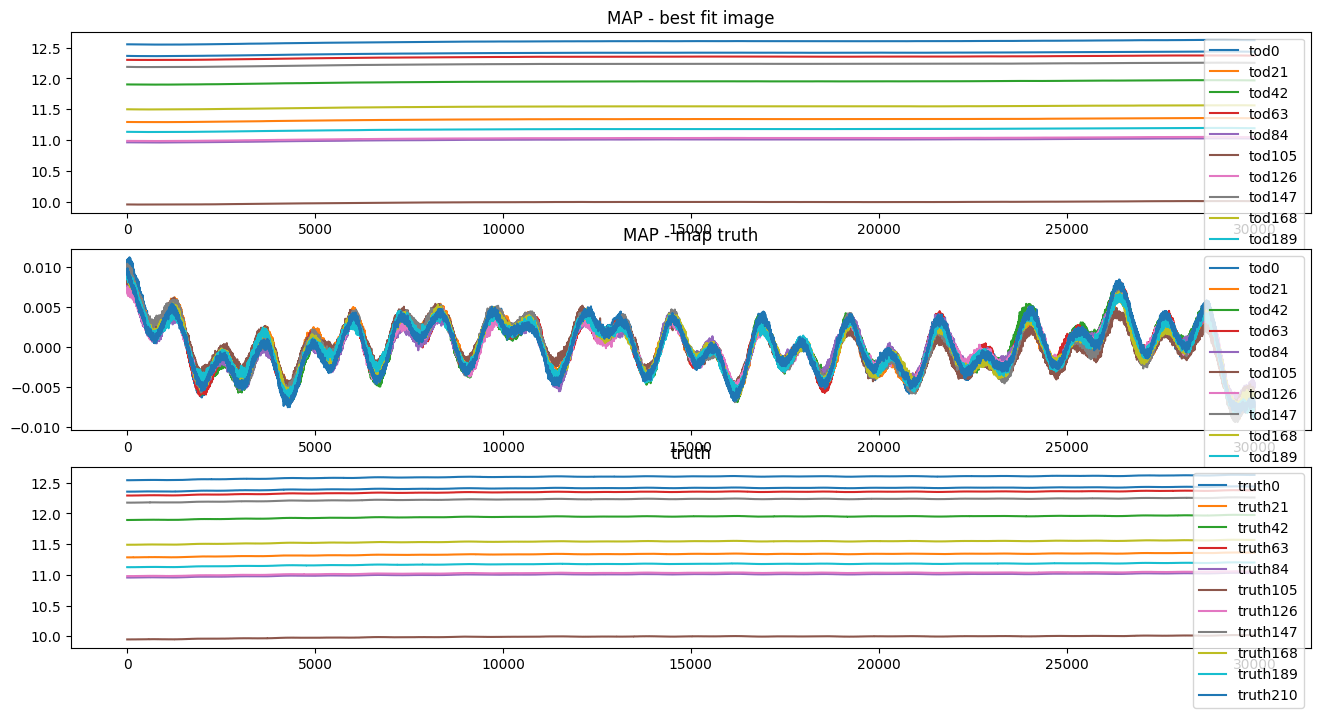

In [21]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [22]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+1.8842e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+1.4080e+08 Δ⛰:1.8842e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+8.0568e+07 Δ⛰:6.0230e+07 ➽:8.6802e+01
SL: Iteration 3 ⛰:+7.8987e+07 Δ⛰:1.5809e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+5.3042e+07 Δ⛰:2.5945e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+5.2628e+07 Δ⛰:4.1416e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+1.5287e+07 Δ⛰:3.7341e+07 ➽:8.6802e+01
SL: Iteration 7 ⛰:+1.5287e+07 Δ⛰:1.7963e+02 ➽:8.6802e+01
SL: Iteration 8 ⛰:+7.9410e+06 Δ⛰:7.3460e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.0468e+06 Δ⛰:5.8941e+06 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.0468e+06 Δ⛰:1.5238e+00 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.5692e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+9.9532e+07 Δ⛰:1.5692e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+8.9641e+07 Δ⛰:9.8912e+06 ➽:8.6802e+01
SL: Iteration 3 ⛰:+8.4068e+07 Δ⛰:5.5735e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+3.4134e+07 Δ⛰:4.9934e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7753e+07 Δ⛰:1.6380e+07 ➽:8.6802e+01
SL: Iteration 6 ⛰

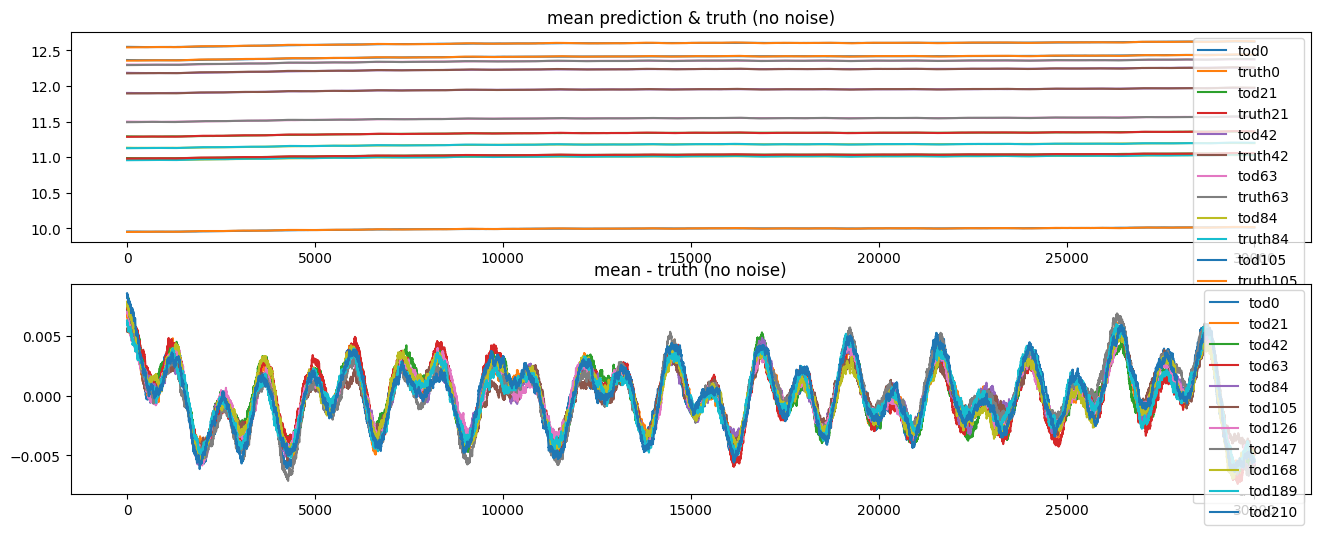

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.8823e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.6505e+08 Δ⛰:1.8823e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.3843e+08 Δ⛰:2.6615e+07 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.0835e+08 Δ⛰:3.0080e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.3195e+08 Δ⛰:7.6405e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.3194e+08 Δ⛰:1.1060e+04 ➽:8.6802e+01
SL: Iteration 6 ⛰:+4.6769e+07 Δ⛰:8.5170e+07 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.6483e+07 Δ⛰:2.8524e+05 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.0173e+07 Δ⛰:1.6310e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.1259e+07 Δ⛰:8.9139e+06 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.0970e+07 Δ⛰:2.8946e+05 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.9501e+07 Δ⛰:1.4684e+06 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.2347e+07 Δ⛰:7.1547e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.2342e+07 Δ⛰:4.9283e+03 ➽:8.6802e+01
SL: Iteration 14 ⛰:+1.2339e+07 Δ⛰:2.4115e+03 ➽:8.6802e+01
SL: Iteration 15 ⛰:+8.8719e+06 Δ⛰:3.4674e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+8.7069e+06 Δ⛰:1.6502e+05 ➽:8.6802e+01
SL: 

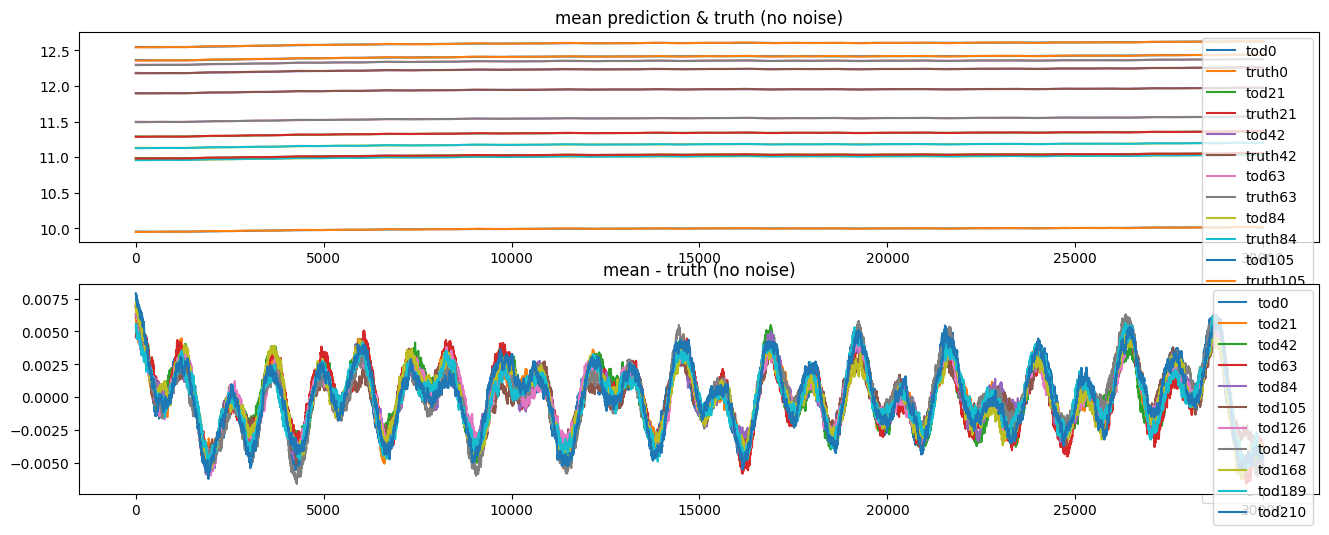

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+1.9915e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+3.2841e+08 Δ⛰:1.9915e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.0303e+08 Δ⛰:1.2538e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+1.9729e+08 Δ⛰:5.7358e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.4112e+08 Δ⛰:5.6169e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.4111e+08 Δ⛰:7.6144e+03 ➽:8.6802e+01
SL: Iteration 6 ⛰:+5.4485e+07 Δ⛰:8.6630e+07 ➽:8.6802e+01
SL: Iteration 7 ⛰:+5.3717e+07 Δ⛰:7.6805e+05 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.5611e+07 Δ⛰:1.8105e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+3.0779e+07 Δ⛰:4.8326e+06 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.4130e+07 Δ⛰:6.6491e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.4035e+07 Δ⛰:9.4336e+04 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.6183e+07 Δ⛰:7.8518e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.6180e+07 Δ⛰:3.9220e+03 ➽:8.6802e+01
SL: Iteration 14 ⛰:+1.2860e+07 Δ⛰:3.3192e+06 ➽:8.6802e+01
SL: Iteration 15 ⛰:+1.2385e+07 Δ⛰:4.7560e+05 ➽:8.6802e+01
SL: Iteration 16 ⛰:+1.2311e+07 Δ⛰:7.3597e+04 ➽:8.6802e+01
SL: 

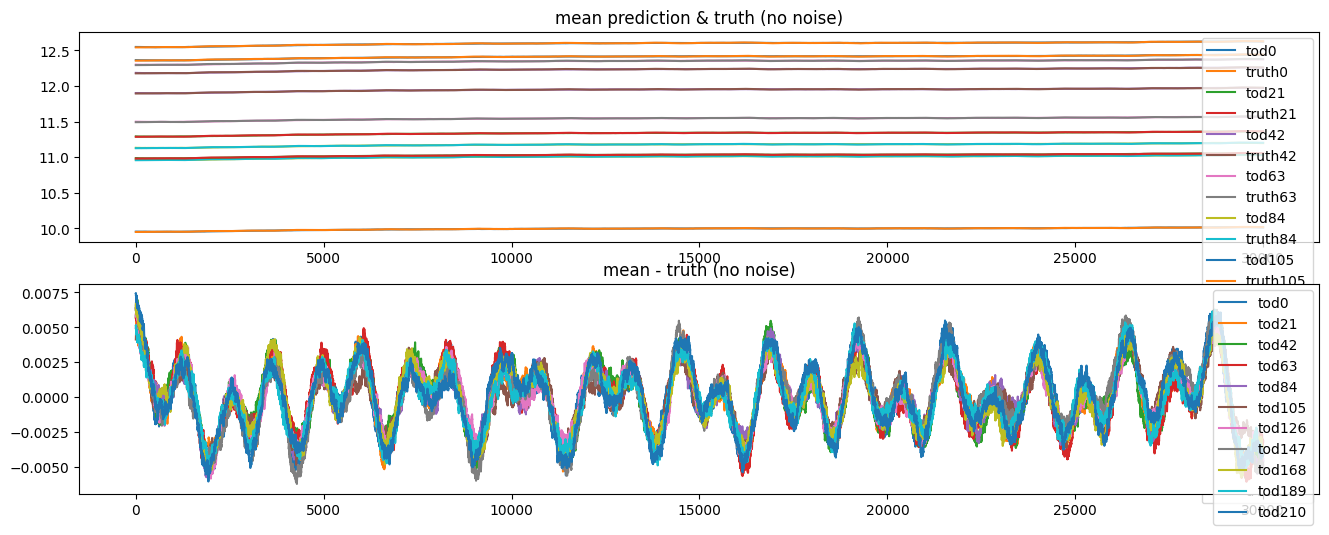

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+1.9232e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+7.2382e+08 Δ⛰:1.9231e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+3.4596e+08 Δ⛰:3.7786e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.7743e+08 Δ⛰:6.8533e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.3720e+08 Δ⛰:1.4023e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.3717e+08 Δ⛰:3.2687e+04 ➽:8.6802e+01
SL: Iteration 6 ⛰:+5.4667e+07 Δ⛰:8.2501e+07 ➽:8.6802e+01
SL: Iteration 7 ⛰:+5.2910e+07 Δ⛰:1.7571e+06 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.6070e+07 Δ⛰:1.6840e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+3.4328e+07 Δ⛰:1.7416e+06 ➽:8.6802e+01
SL: Iteration 10 ⛰:+3.3852e+07 Δ⛰:4.7683e+05 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.4984e+07 Δ⛰:8.8671e+06 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.7138e+07 Δ⛰:7.8466e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.7135e+07 Δ⛰:3.1227e+03 ➽:8.6802e+01
SL: Iteration 14 ⛰:+1.7088e+07 Δ⛰:4.6981e+04 ➽:8.6802e+01
SL: Iteration 15 ⛰:+1.2982e+07 Δ⛰:4.1054e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+1.2787e+07 Δ⛰:1.9551e+05 ➽:8.6802e+01
SL: 

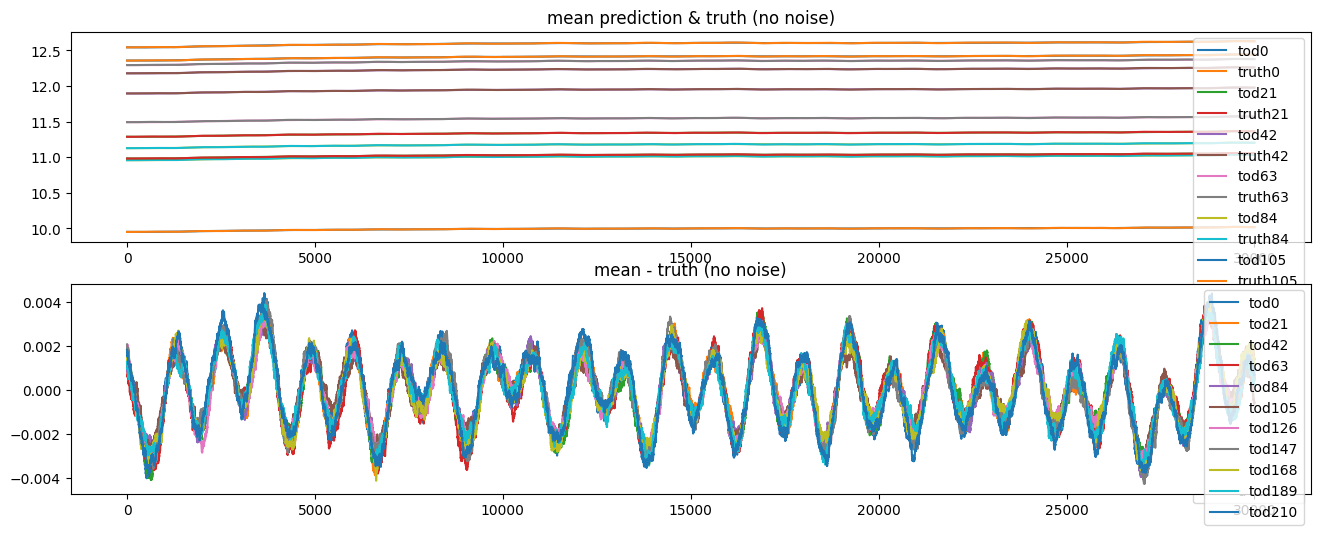

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+2.2413e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+1.1130e+10 Δ⛰:2.2402e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+3.3345e+08 Δ⛰:1.0797e+10 ➽:8.6802e+01
SL: Iteration 3 ⛰:+1.6715e+08 Δ⛰:1.6629e+08 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.5408e+08 Δ⛰:1.3079e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.5405e+08 Δ⛰:2.8895e+04 ➽:8.6802e+01
SL: Iteration 6 ⛰:+5.0727e+07 Δ⛰:1.0332e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.1157e+07 Δ⛰:9.5691e+06 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.0888e+07 Δ⛰:1.0269e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.8878e+07 Δ⛰:1.2011e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.7547e+07 Δ⛰:1.3313e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.7492e+07 Δ⛰:5.4365e+04 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.0299e+07 Δ⛰:7.1933e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.0297e+07 Δ⛰:1.4689e+03 ➽:8.6802e+01
SL: Iteration 14 ⛰:+1.0295e+07 Δ⛰:2.0112e+03 ➽:8.6802e+01
SL: Iteration 15 ⛰:+7.1523e+06 Δ⛰:3.1431e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+7.1042e+06 Δ⛰:4.8120e+04 ➽:8.6802e+01
SL: 

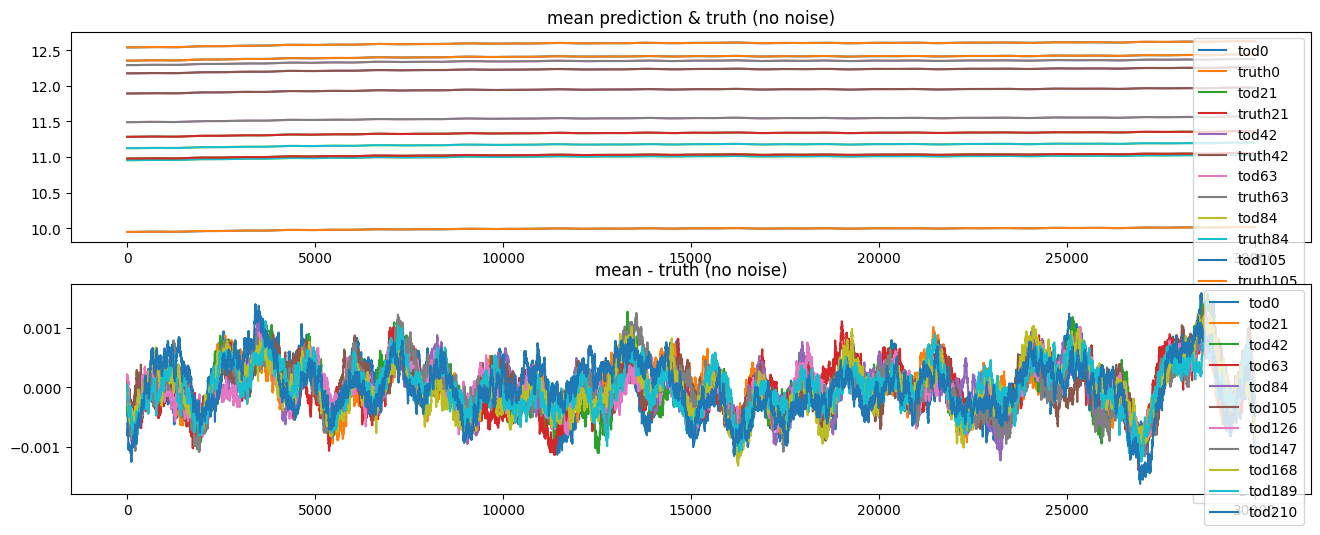

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+1.8513e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+1.0579e+09 Δ⛰:1.8512e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.5380e+08 Δ⛰:8.0411e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.5179e+08 Δ⛰:2.0102e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.8787e+08 Δ⛰:6.3927e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.8774e+08 Δ⛰:1.3165e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+5.5018e+07 Δ⛰:1.3272e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+5.1026e+07 Δ⛰:3.9919e+06 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.2909e+07 Δ⛰:1.8117e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.9664e+07 Δ⛰:1.3245e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.7480e+07 Δ⛰:2.1840e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.7463e+07 Δ⛰:1.6971e+04 ➽:8.6802e+01
SL: Iteration 12 ⛰:+9.6866e+06 Δ⛰:7.7765e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+9.6865e+06 Δ⛰:8.5829e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.6435e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+3.3335e+09 Δ⛰:1.6431e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+6.1541e+08 Δ⛰:2.7181e+09 ➽:8.6802e+01
SL: Iteration 

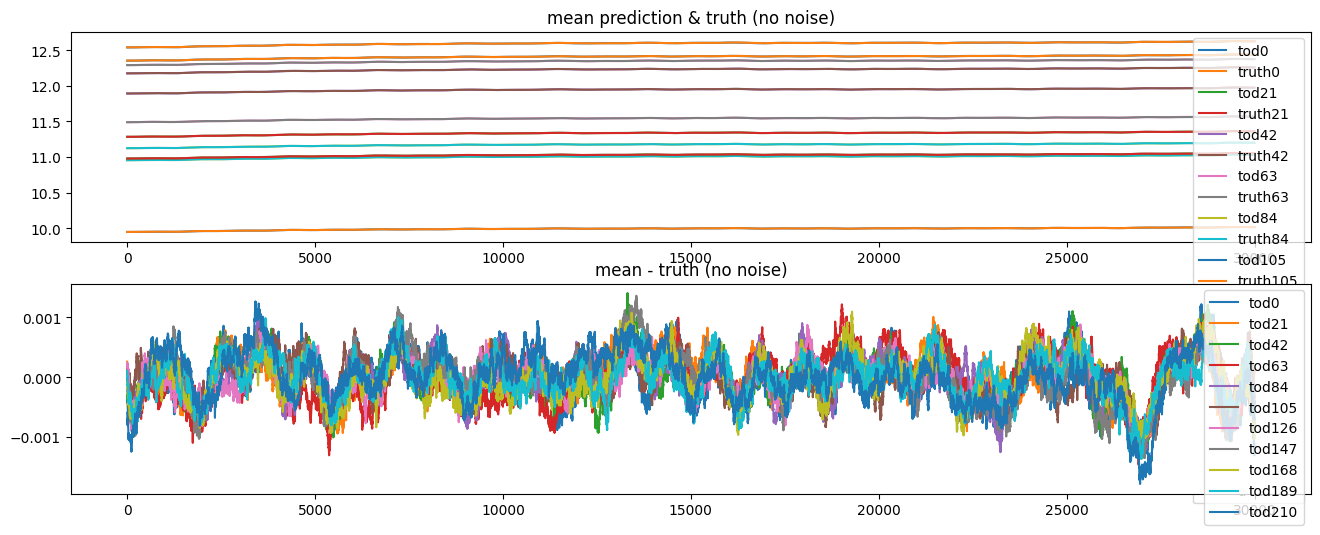

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+1.4239e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.2407e+09 Δ⛰:1.4237e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+9.7430e+08 Δ⛰:1.2664e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+9.4379e+08 Δ⛰:3.0512e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.7841e+08 Δ⛰:7.6538e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7781e+08 Δ⛰:5.9690e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+5.3894e+07 Δ⛰:1.2392e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.2614e+07 Δ⛰:1.1280e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.2556e+07 Δ⛰:1.0058e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.7752e+07 Δ⛰:1.4804e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.7455e+07 Δ⛰:2.9738e+05 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.7455e+07 Δ⛰:2.6447e+02 ➽:8.6802e+01
SL: Iteration 12 ⛰:+9.9811e+06 Δ⛰:7.4734e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+9.9603e+06 Δ⛰:2.0857e+04 ➽:8.6802e+01
SL: Iteration 14 ⛰:+9.7182e+06 Δ⛰:2.4206e+05 ➽:8.6802e+01
SL: Iteration 15 ⛰:+6.5048e+06 Δ⛰:3.2135e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+6.5034e+06 Δ⛰:1.3173e+03 ➽:8.6802e+01
SL: 

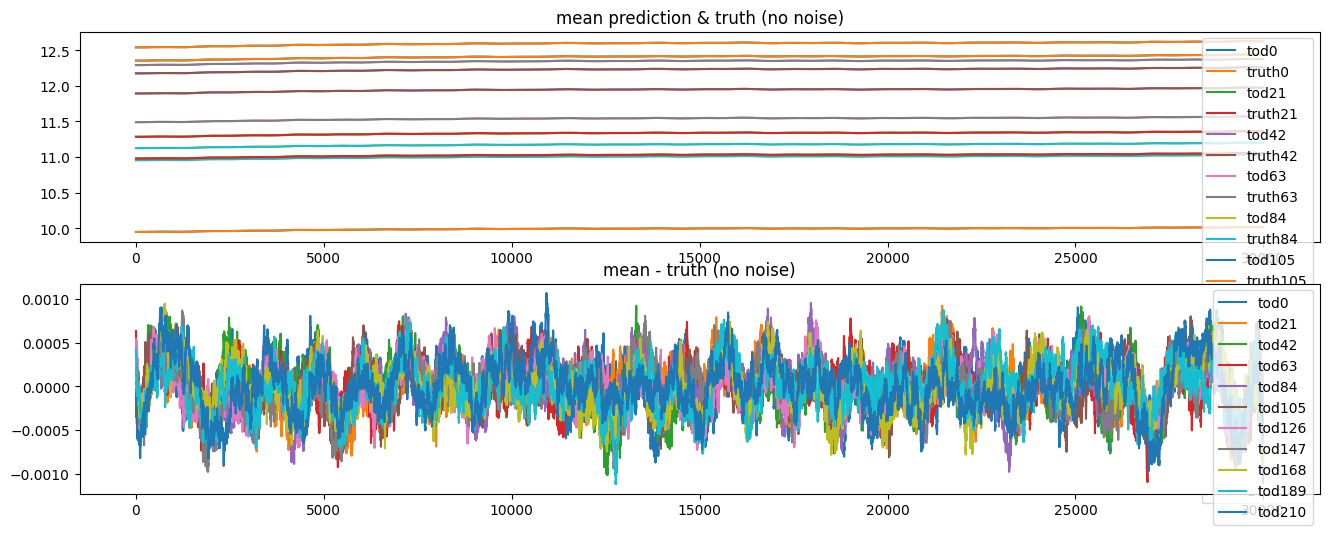

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+1.8998e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+9.7275e+09 Δ⛰:1.8989e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+3.4366e+08 Δ⛰:9.3839e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+3.1889e+08 Δ⛰:2.4763e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.7832e+08 Δ⛰:1.4057e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7765e+08 Δ⛰:6.7166e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+4.9887e+07 Δ⛰:1.2776e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+3.2857e+07 Δ⛰:1.7030e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.1471e+07 Δ⛰:1.3858e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.7354e+07 Δ⛰:1.4117e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.7295e+07 Δ⛰:5.9716e+04 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.7178e+07 Δ⛰:1.1648e+05 ➽:8.6802e+01
SL: Iteration 12 ⛰:+9.9112e+06 Δ⛰:7.2670e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+9.9108e+06 Δ⛰:4.4856e+02 ➽:8.6802e+01
SL: Iteration 14 ⛰:+9.8797e+06 Δ⛰:3.1055e+04 ➽:8.6802e+01
SL: Iteration 15 ⛰:+7.7904e+06 Δ⛰:2.0893e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+7.7904e+06 Δ⛰:7.4116e+01 ➽:8.6802e+01
SL: 

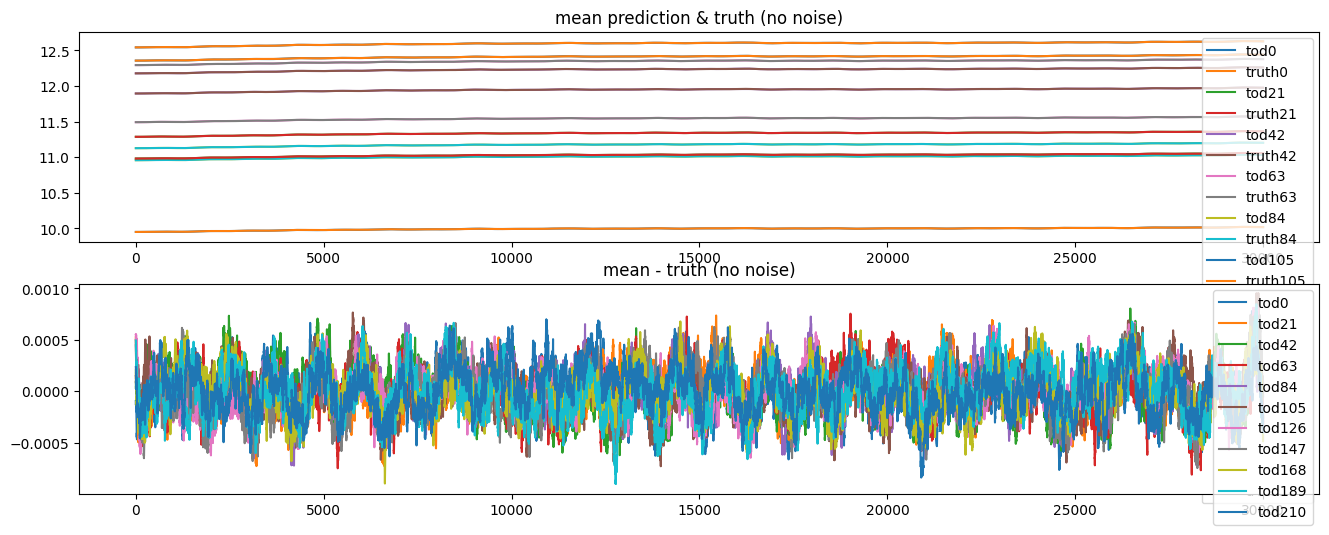

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+1.6485e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+5.8781e+09 Δ⛰:1.6479e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+1.2031e+09 Δ⛰:4.6750e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+1.1750e+09 Δ⛰:2.8088e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.9493e+08 Δ⛰:9.8012e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.9454e+08 Δ⛰:3.8298e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+5.4913e+07 Δ⛰:1.3963e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.1334e+07 Δ⛰:1.3580e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.3089e+07 Δ⛰:8.2441e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.8279e+07 Δ⛰:1.4811e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.7501e+07 Δ⛰:7.7783e+05 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.7295e+07 Δ⛰:2.0550e+05 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.0212e+07 Δ⛰:7.0829e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.0194e+07 Δ⛰:1.8234e+04 ➽:8.6802e+01
SL: Iteration 14 ⛰:+9.9432e+06 Δ⛰:2.5081e+05 ➽:8.6802e+01
SL: Iteration 15 ⛰:+8.3574e+06 Δ⛰:1.5859e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+8.3572e+06 Δ⛰:1.8963e+02 ➽:8.6802e+01
SL: 

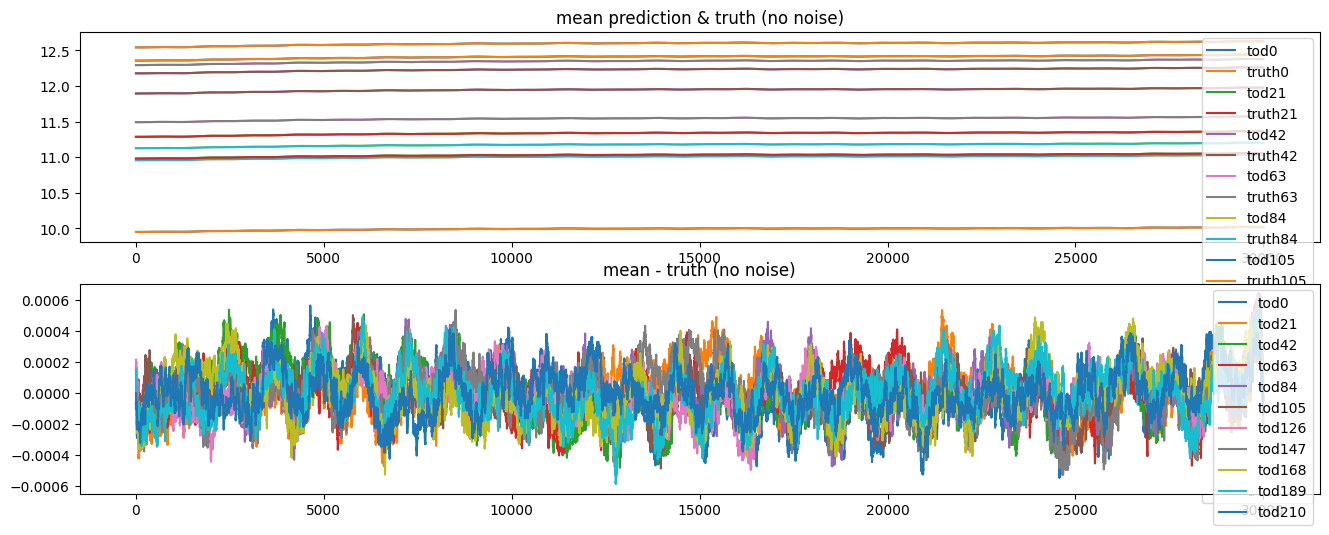

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+1.9230e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+8.4964e+09 Δ⛰:1.9221e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+1.3245e+09 Δ⛰:7.1719e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+1.3019e+09 Δ⛰:2.2585e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.0450e+08 Δ⛰:1.0974e+09 ➽:8.6802e+01
SL: Iteration 5 ⛰:+2.0399e+08 Δ⛰:5.0664e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+4.9943e+07 Δ⛰:1.5405e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.2878e+07 Δ⛰:7.0652e+06 ➽:8.6802e+01
SL: Iteration 8 ⛰:+2.9150e+07 Δ⛰:1.3728e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.4618e+07 Δ⛰:1.4532e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.3279e+07 Δ⛰:1.3393e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.3161e+07 Δ⛰:1.1771e+05 ➽:8.6802e+01
SL: Iteration 12 ⛰:+6.7799e+06 Δ⛰:6.3811e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+6.7788e+06 Δ⛰:1.1058e+03 ➽:8.6802e+01
SL: Iteration 14 ⛰:+6.7385e+06 Δ⛰:4.0229e+04 ➽:8.6802e+01
SL: Iteration 15 ⛰:+5.5598e+06 Δ⛰:1.1787e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+5.5581e+06 Δ⛰:1.7306e+03 ➽:8.6802e+01
SL: 

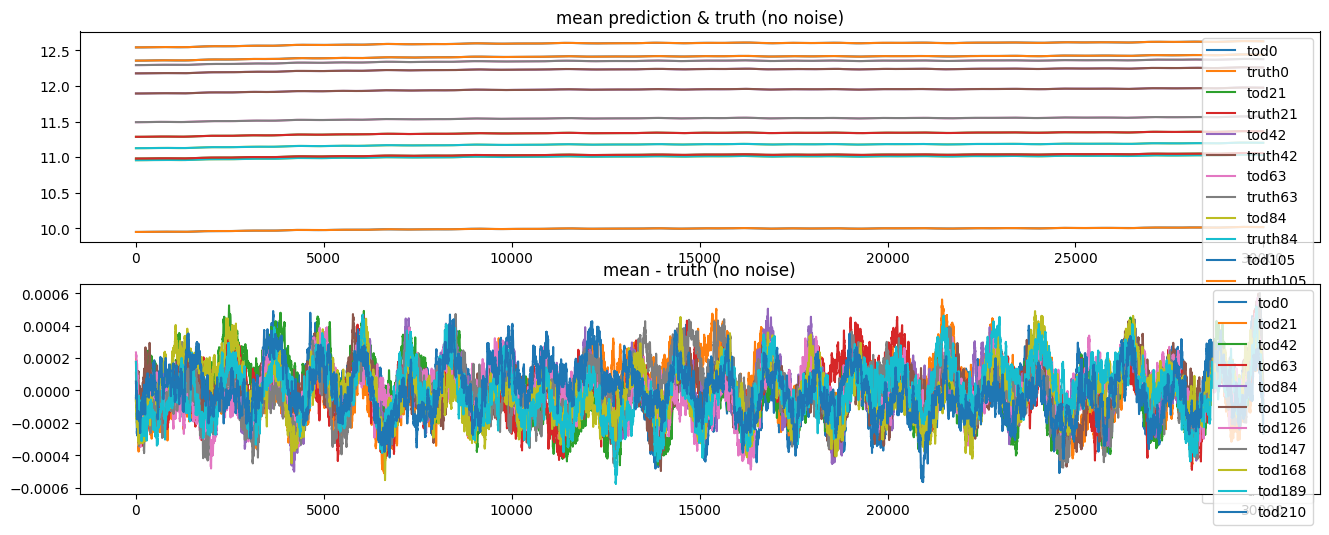

In [23]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    for i in range(0, n, n//10 if n//10 != 0 else 1):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

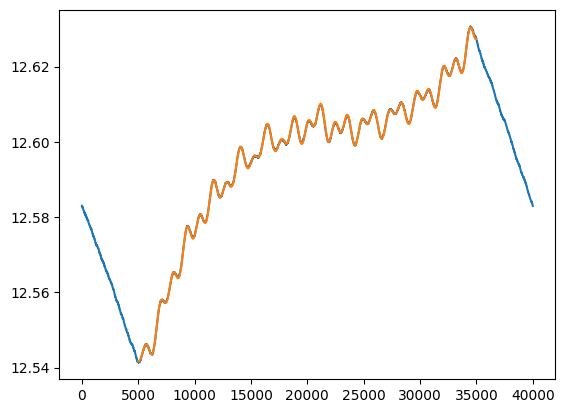

In [26]:
offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
pred = gp_tod({k: samples.pos[k] for k in samples.pos if 'comb' in k}) + offset_results[0, np.newaxis]
padded_truth = np.pad(jax_tods_atmos[0], pad_width=padding_atmos//2, mode='constant', constant_values=np.nan)

plt.plot(pred[0])
plt.plot(padded_truth)

In [25]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.001953486213283843, 0.002, 0.001
	loglogvarslope: -2.4771069407986235, -2.5, 0.5
	zeromode std (LogNormal): 0.000277924019184334, 0.0002, 0.0001


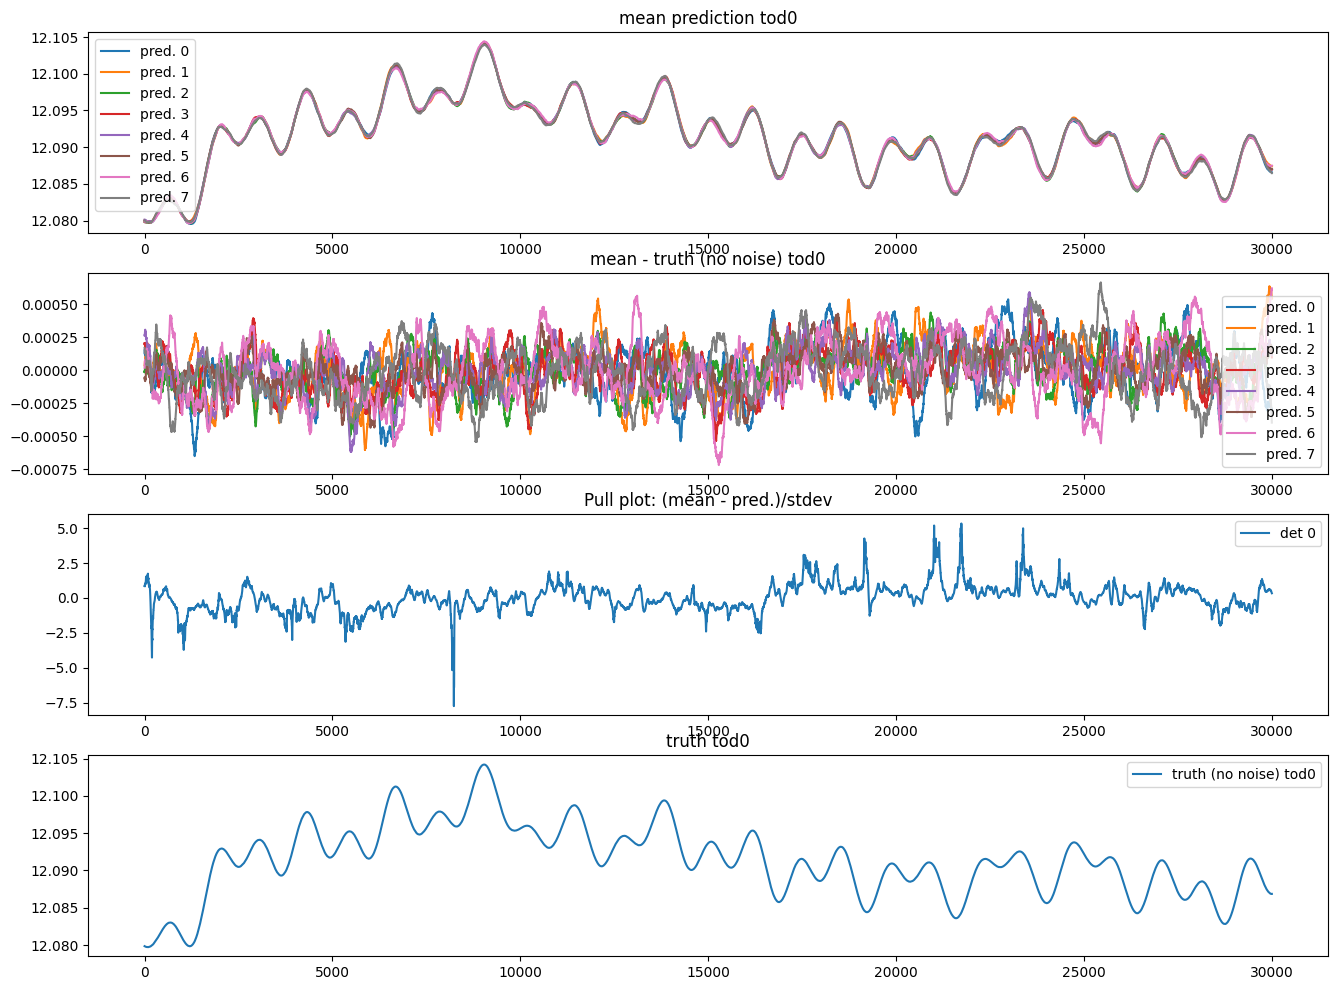

In [26]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

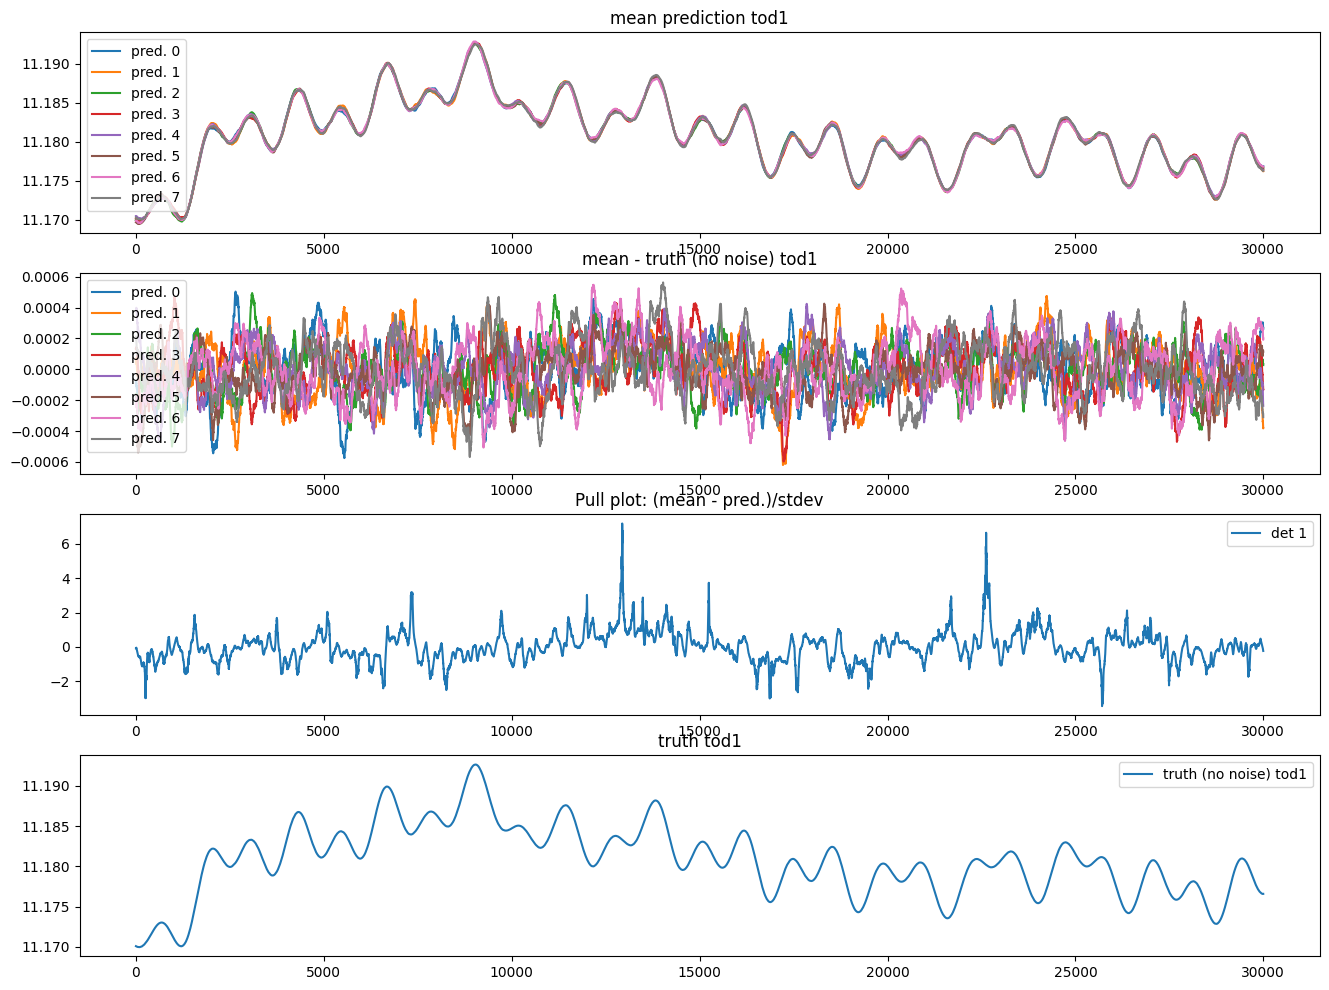

In [27]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()